In [1]:
# !pip install tensorflow

import os
import numpy as np
import cv2
from ultralytics import YOLO
from tensorflow.keras.utils import to_categorical # This line was causing the error
from sklearn.model_selection import train_test_split


C:\Users\2002n\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [5]:
DATASET_PATH = "D:/ISP_robo/frame_unsafe"  # Path to the folder containing label subfolders
IMAGE_SIZE = (64, 64)
SEQUENCE_LENGTH = 10  # **Consider lowering if you have fewer frames per sequence**
LABELS = ['opened_panel', 'unauthorized_intervention', 'overload_forklift', 'unsafe_walkway']
label2idx = {label: idx for idx, label in enumerate(LABELS)}

X = []
y = []

for label in LABELS:
    class_path = os.path.join(DATASET_PATH, label)
    # Check if the label folder exists
    if not os.path.exists(class_path):
        print(f"Warning: Label folder '{label}' not found in '{DATASET_PATH}'. Skipping...")
        continue

    for filename in os.listdir(class_path):
        if filename.endswith((".jpg", ".jpeg", ".png")):  # Check for image files
            frames = []
            img_path = os.path.join(class_path, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, IMAGE_SIZE)
            frames.append(img / 255.0)

            # Pad with the same image if needed
            while len(frames) < SEQUENCE_LENGTH:
                frames.append(frames[0])

            X.append(frames)
            y.append(label2idx[label])

X = np.array(X)
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, Conv3D, Flatten, Dense

model = Sequential([
    ConvLSTM2D(filters=32, kernel_size=(3, 3), activation='relu',
               input_shape=(SEQUENCE_LENGTH, IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
               return_sequences=True),
    BatchNormalization(),

    ConvLSTM2D(filters=64, kernel_size=(3, 3), activation='relu', return_sequences=False),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(LABELS), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

C:\Users\2002n\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)             │ (None, 10, 62, 62, 32)      │          40,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 10, 62, 62, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)           │ (None, 60, 60, 64)          │         221,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 60, 60, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 230400)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      29,491,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,754,116 (113.50 MB)

 Trainable params: 29,753,924 (113.50 MB)

 Non-trainable params: 192 (768.00 B)

In [12]:
history = model.fit(X_train, y_train, epochs=25, batch_size=8, validation_split=0.2)

# Define your desired save path in your Drive
# save_path = "D:/convlstm_model.h5"

#Save the model

# model.save(save_path)
# print("Model saved to Drive!")

Epoch 1/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 631s 9s/step - accuracy: 0.7288 - loss: 23.1744 - val_accuracy: 0.1429 - val_loss: 35.7160
Epoch 2/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 374s 7s/step - accuracy: 0.8495 - loss: 2.7492 - val_accuracy: 0.1429 - val_loss: 92.2235
Epoch 3/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 367s 7s/step - accuracy: 0.9099 - loss: 0.9204 - val_accuracy: 0.1429 - val_loss: 121.9195
Epoch 4/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 358s 7s/step - accuracy: 0.8720 - loss: 2.7290 - val_accuracy: 0.1429 - val_loss: 106.8142
Epoch 5/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 381s 7s/step - accuracy: 0.9113 - loss: 1.6102 - val_accuracy: 0.1429 - val_loss: 118.5740
Epoch 6/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 383s 7s/step - accuracy: 0.9489 - loss: 0.9447 - val_accuracy: 0.1429 - val_loss: 90.2306
Epoch 8/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 367s 7s/step - accuracy: 0.9847 - loss: 0.0934 - val_accuracy: 0.1429 - val_loss: 67.2326
Epoch 9/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 366s 7s/step - accuracy: 0.9618 - loss: 0.2996 - val_accuracy:

Model saved to Drive!


In [7]:
from tensorflow import keras

# Load the model
Keras_model = keras.models.load_model("D:/ISP_robo/my_model.keras")

In [8]:
y_pred = Keras_model.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 63s 8s/step


In [9]:
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Accuracy:", accuracy_score(y_true_labels, y_pred_labels))


Accuracy: 0.9465648854961832


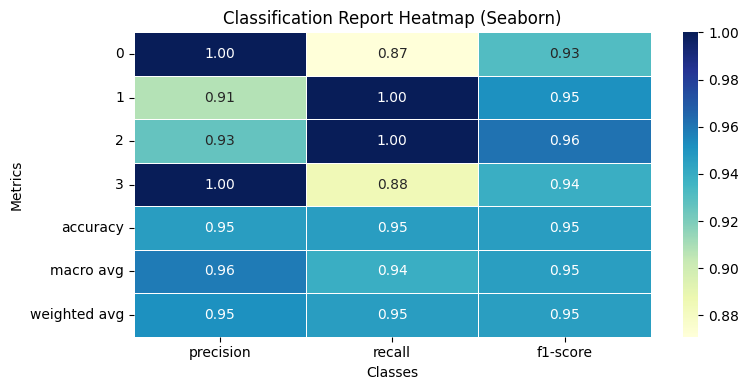

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import pandas as pd

# Get classification report as a dictionary
report = classification_report(y_true_labels, y_pred_labels, output_dict=True)

# Convert to DataFrame (exclude support/accuracy row for clarity)
df = pd.DataFrame(report).iloc[:-1, :].T  # Transpose so metrics are rows

# Plot with seaborn
plt.figure(figsize=(8, 4))
sns.heatmap(df, annot=True, cmap="YlGnBu", fmt=".2f", linewidths=0.5)

plt.title("Classification Report Heatmap (Seaborn)")
plt.ylabel("Metrics")
plt.xlabel("Classes")
plt.tight_layout()
plt.show()


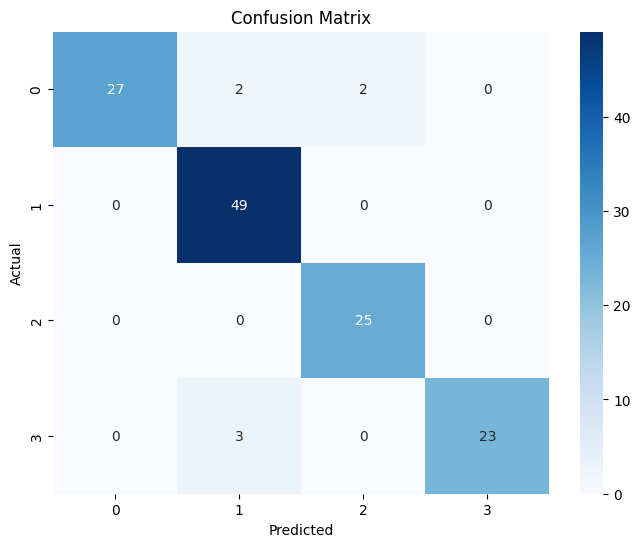

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [13]:
# from keras.saving import save_model

# Specify the full path including the filename with .keras extension
# save_model(model, "D:/my_model.keras")